# Forecasting Multiple Time Series

> Forecast the M5 dataset

In this notebook we show how to use `StatsForecast` to forecast thounsands of time series.

In this example, we used a ray cluster (AWS) of 11 instances of type m5.2xlarge (8 cores, 32 GB RAM).

## Installing StatsForecast Library

In [ ]:
%%capture
!pip install statsforecast datasetforecast s3fs pyarrow

## Download data

The example uses the [M5 dataset](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf). It consists of `30,490` bottom time series. 

In [ ]:
import pandas as pd

In [ ]:
Y_df = pd.read_parquet('s3://m5-benchmarks/data/train/target.parquet')
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [ ]:
Y_df = Y_df.query('unique_id.str.startswith("FOODS_3")')
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

In [ ]:
Y_df.head()

unique_id         ds    y
9204645  FOODS_3_001_CA_1 2011-01-29  1.0
9204646  FOODS_3_001_CA_1 2011-01-30  1.0
9204647  FOODS_3_001_CA_1 2011-01-31  1.0
9204648  FOODS_3_001_CA_1 2011-02-01  1.0
9204649  FOODS_3_001_CA_1 2011-02-02  1.0

In [ ]:
Y_df['unique_id'].nunique()

8230

In [ ]:
uids = Y_df['unique_id'].unique()

In [ ]:
from statsforecast import StatsForecast

/home/ubuntu/fede/statsforecast/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


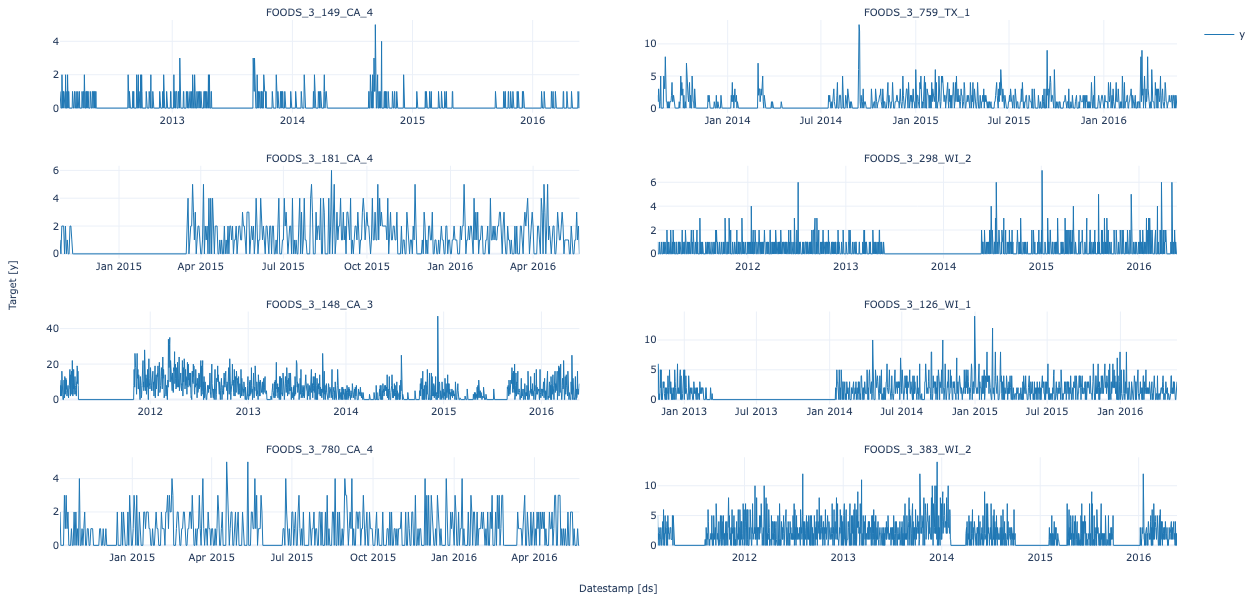

In [ ]:
StatsForecast.plot(Y_df)

## Perform cross validation

`StatsForecast` receives a list of models to fit each time series. Since we are dealing with Daily data, it would be benefitial to use 7 as seasonality.

In [ ]:
from statsforecast.models import (
    SeasonalNaive,
    Naive,
    HistoricAverage,
    CrostonOptimized,
    ADIDA,
    IMAPA,
    AutoETS
)

In [ ]:
horizon = 28
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7)
]

In [ ]:
sf = StatsForecast(
    models=models, 
    freq='D', 
    n_jobs=-1,
)

In [ ]:
from time import time

In [ ]:
init = time()
cv_df = sf.cross_validation(df=Y_df, h=horizon, step_size=horizon, n_windows=3, level=[90], input_size=28)
end = time()
print(f'CV Minutes: {(end - init) / 60}')

/home/ubuntu/fede/statsforecast/statsforecast/ets.py:1039: RuntimeWarning:

divide by zero encountered in divide



CV Minutes: 0.9749490896860759


In [ ]:
cutoffs = cv_df['cutoff'].unique()

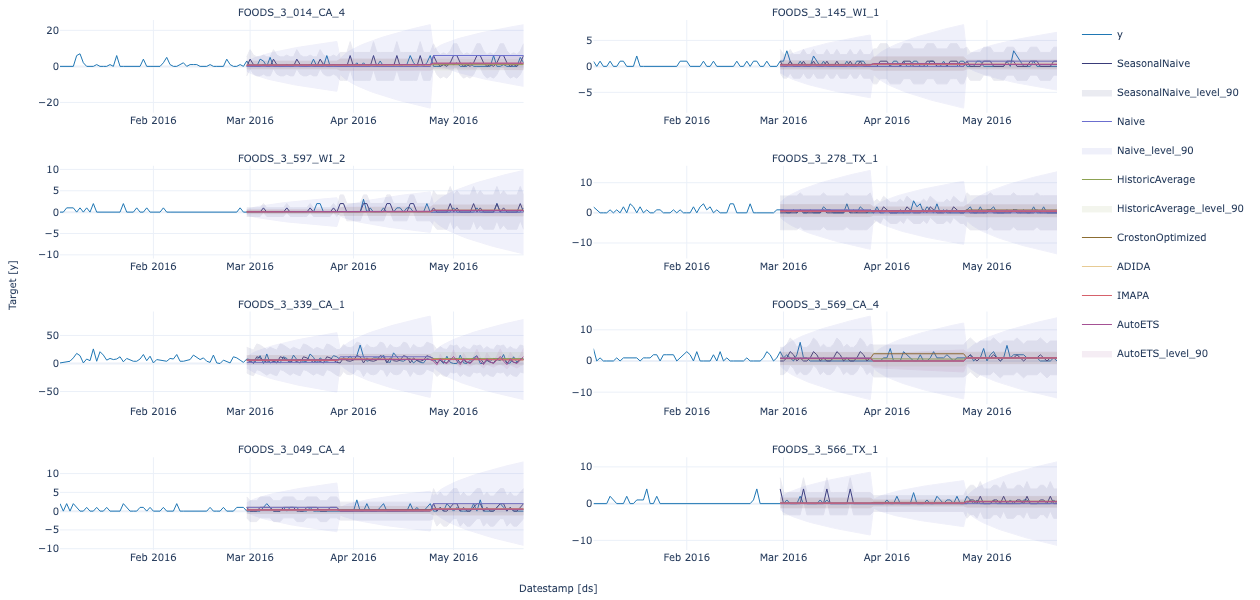

In [ ]:
sf.plot(Y_df, cv_df.drop(columns=['y', 'cutoff']), max_insample_length=28 * 5, level=[90])

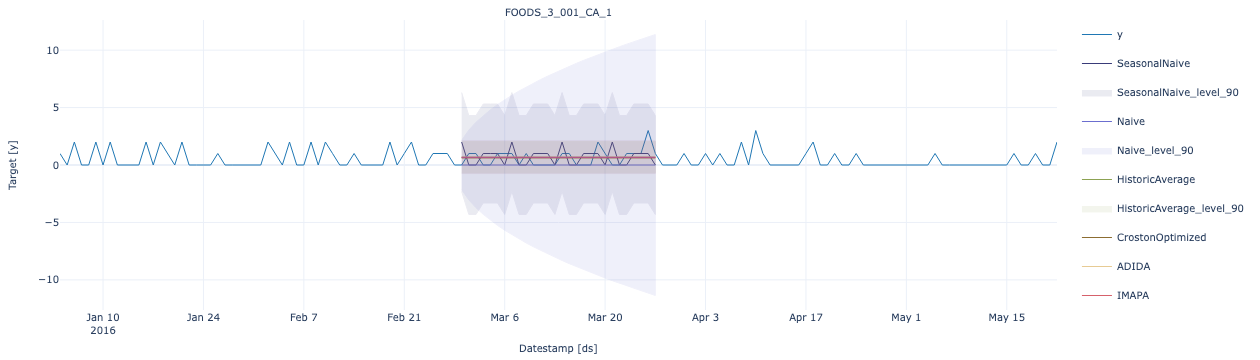

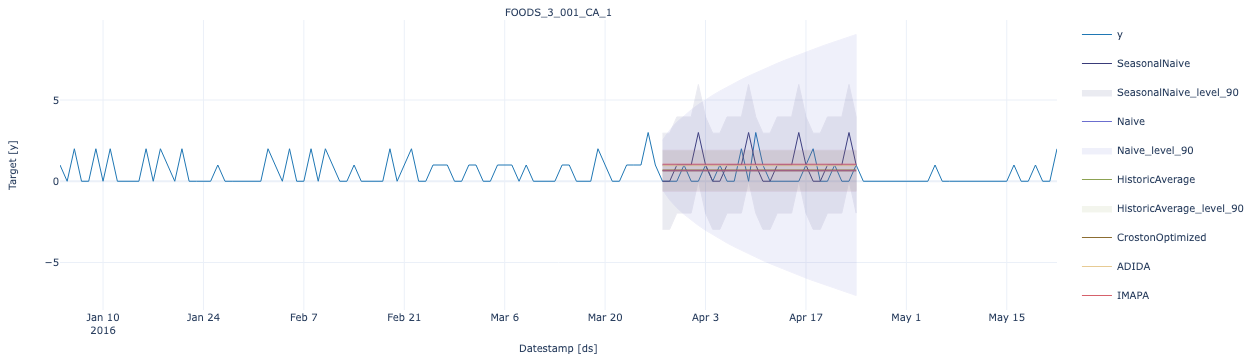

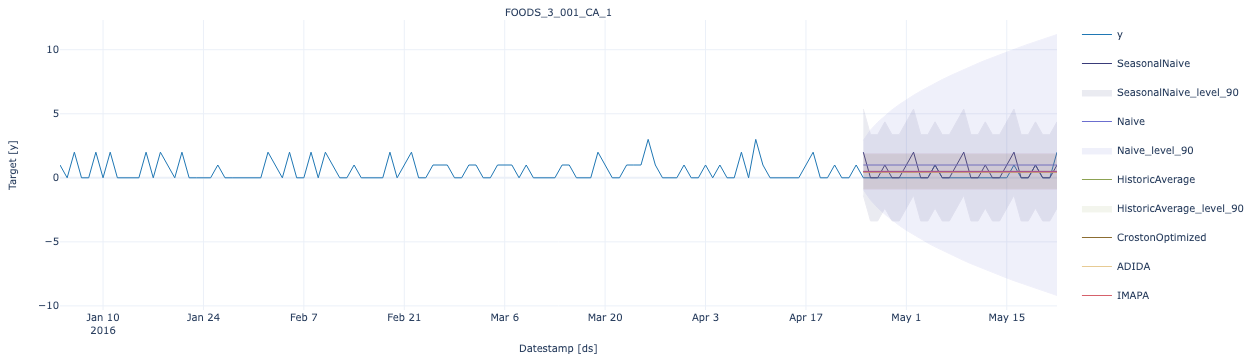

In [ ]:
for cutoff in cutoffs:
    sf.plot(Y_df, 
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
            max_insample_length=28 * 5, 
            unique_ids=['FOODS_3_001_CA_1'],
            level=[90])

In [ ]:
agg_cv_df = cv_df.loc[:,~cv_df.columns.str.contains('hi|lo')].groupby(['ds', 'cutoff']).sum().reset_index()
agg_cv_df.insert(0, 'unique_id', 'agg_demand')
agg_cv_df.head()

unique_id         ds     cutoff        y  SeasonalNaive    Naive  \
0  agg_demand 2016-02-29 2016-02-28  16648.0        16664.0  22991.0   
1  agg_demand 2016-03-01 2016-02-28  16287.0        15362.0  22991.0   
2  agg_demand 2016-03-02 2016-02-28  17192.0        15220.0  22991.0   
3  agg_demand 2016-03-03 2016-02-28  18094.0        16012.0  22991.0   
4  agg_demand 2016-03-04 2016-02-28  17364.0        16936.0  22991.0   

   HistoricAverage  CrostonOptimized         ADIDA         IMAPA       AutoETS  
0     19130.529297      20014.041016  19062.710938  19133.822266  19019.697266  
1     19130.529297      20014.041016  19062.710938  19133.822266  18802.601562  
2     19130.529297      20014.041016  19062.710938  19133.822266  18907.947266  
3     19130.529297      20014.041016  19062.710938  19133.822266  19020.572266  
4     19130.529297      20014.041016  19062.710938  19133.822266  19325.921875

In [ ]:
agg_Y_df = Y_df.groupby(['ds']).sum(numeric_only=True).reset_index()
agg_Y_df.insert(0, 'unique_id', 'agg_demand')

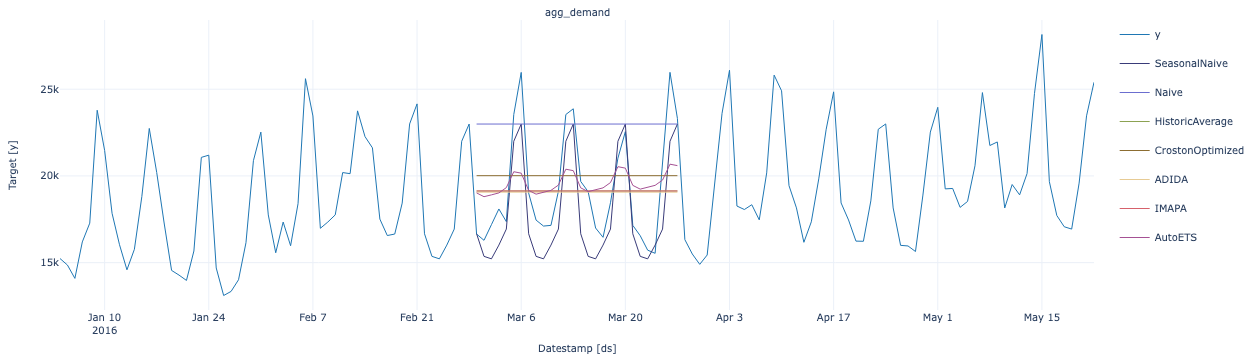

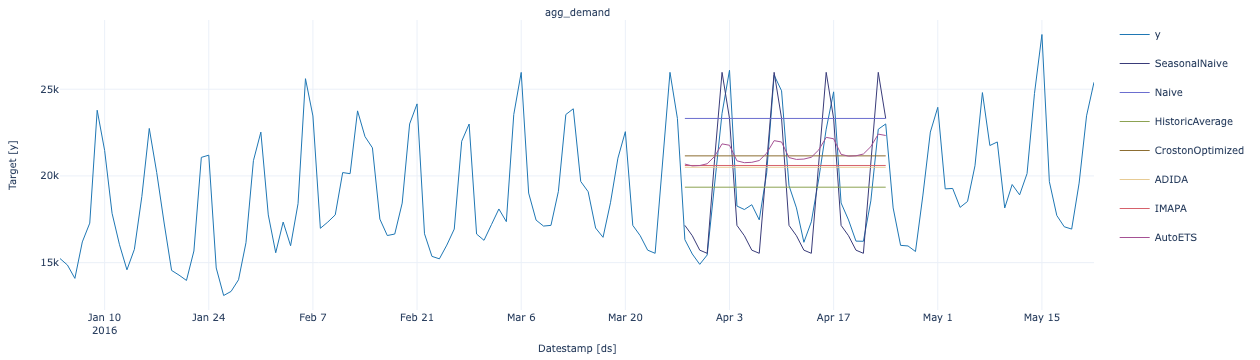

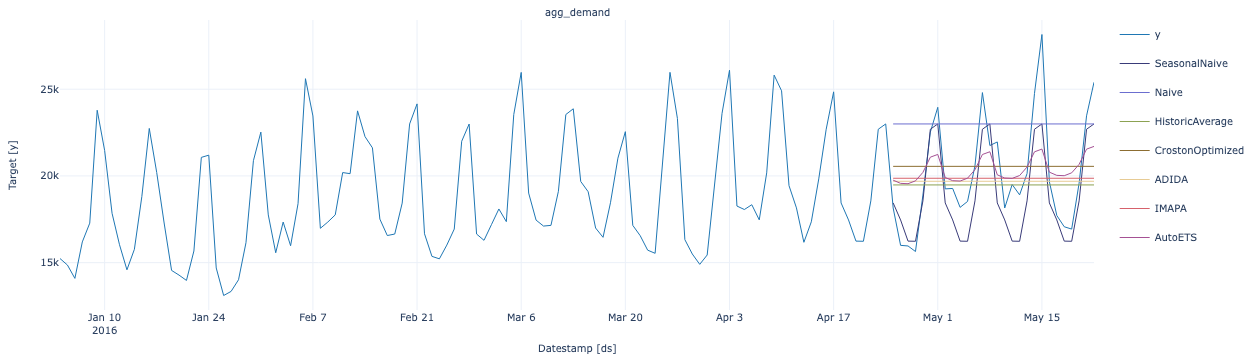

In [ ]:
for cutoff in cutoffs:
    sf.plot(agg_Y_df, 
            agg_cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=28 * 5)

In [ ]:
from datasetsforecast.losses import mse, mae, smape

In [ ]:
from typing import List, Callable

In [ ]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [ ]:
from fugue import transform

In [ ]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns

In [ ]:
str_models = ','.join([f"{model}:float" for model in str_models])

In [ ]:
cv_df['cutoff'] = cv_df['cutoff'].astype(str)

In [ ]:
cv_df = cv_df.reset_index()

In [ ]:
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [ ]:
evaluate(cv_df.query('unique_id == "FOODS_3_001_CA_1" & cutoff == "2016-02-28"'), metrics=[mse])

unique_id      cutoff metric  SeasonalNaive     Naive  \
0  FOODS_3_001_CA_1  2016-02-28    mse       1.071429  0.928571   

   HistoricAverage  CrostonOptimized     ADIDA     IMAPA   AutoETS  
0         0.516582          0.515928  0.516636  0.515328  0.516544

In [ ]:
from distributed import Client
client = Client() # without this, dask is not in distributed mode
from fugue_dask import DaskExecutionEngine

# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

/home/ubuntu/miniconda/envs/statsforecast/lib/python3.10/site-packages/distributed/dashboard/core.py:20: UserWarning:


Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.0.2.
Continuing without the dashboard.



In [ ]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine=engine, #"dask",
    #engine_conf={"fugue.dask.dataframe.default.partitions": 96},
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)

In [ ]:
evaluation_df['cutoff'] = pd.to_datetime(evaluation_df['cutoff'])

In [ ]:
evaluation_df.groupby(['cutoff', 'metric']).mean()

/tmp/ipykernel_102934/3855259074.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



SeasonalNaive      Naive  HistoricAverage  \
cutoff     metric                                              
2016-02-28 mae          1.744289   2.040496         1.516469   
           mse         14.510710  19.080585        10.833869   
           smape       85.202042  87.719086       111.990555   
2016-03-27 mae          1.795973   2.106449         1.533911   
           mse         14.810259  26.044472        10.477906   
           smape       87.407471  89.453247       112.714714   
2016-04-24 mae          1.785983   1.990774         1.541847   
           mse         13.476350  16.234917        10.362277   
           smape       89.238815  90.685867       114.987923   

                   CrostonOptimized       ADIDA       IMAPA     AutoETS  
cutoff     metric                                                        
2016-02-28 mae             1.581695    1.534496    1.536534    1.620993  
           mse            11.441593   11.158258   11.195016   14.082161  
           smape         111.451569  113.757927  113.675667  113.472603  
2016-03-27 mae             1.624289    1.587990    1.589002    1.702389  
           mse            12.087269   12.131243   12.131521   17.165882  
           smape         112.429581  114.457344  114.316505  114.101669  
2016-04-24 mae             1.612075    1.548616    1.540517    1.611976  
           mse            10.867298   10.424200   10.210446   11.853121  
           smape         114.421707  116.225746  115.819275  115.646690

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model')

<AxesSubplot: xlabel='value', ylabel='model'>

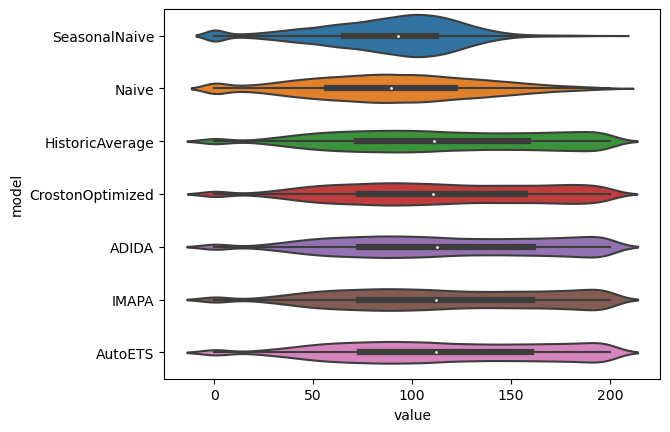

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='value', y='model')

<AxesSubplot: xlabel='value', ylabel='model'>

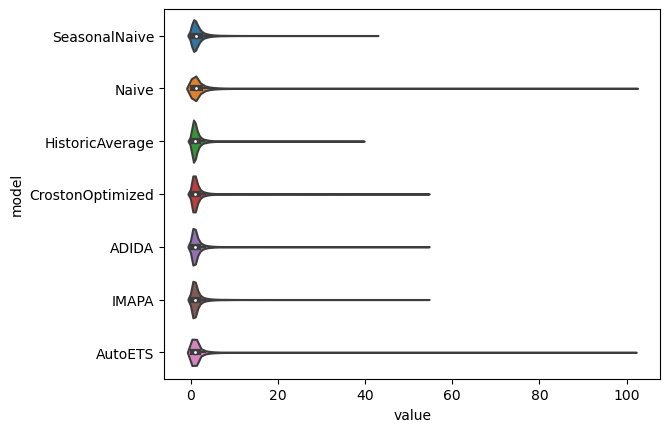

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="mae"'), x='value', y='model')

In [ ]:
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)

In [ ]:
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()

<AxesSubplot: xlabel='n', ylabel='best_model'>

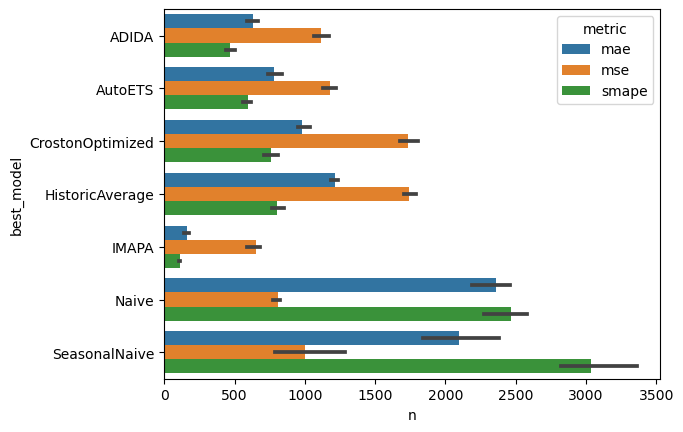

In [ ]:
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')

In [ ]:
eval_series_df = evaluation_df.groupby(['unique_id']).mean(numeric_only=True)

In [ ]:
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)

In [ ]:
counts_series = eval_series_df.value_counts('best_model')

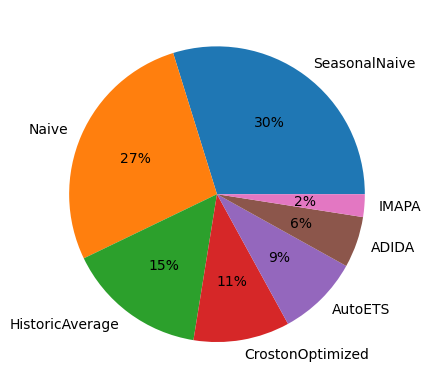

In [ ]:
plt.pie(counts_series, labels=counts_series.index, autopct='%.0f%%')
plt.show()

## Forecast

In [ ]:
init = time()
fcst_df = sf.forecast(df=Y_df.groupby('unique_id').tail(28), h=28, level=[90])
end = time()
print(f'Forecast Minutes: {(end - init) / 60}')

Forecast Minutes: 0.8012702345848084


In [ ]:
fcst_df = pd.melt(fcst_df, id_vars=['ds'], var_name='model', value_name='forecast', ignore_index=False)

In [ ]:
fcst_df = fcst_df.join(eval_series_df[['best_model']]).query("model == best_model").filter(['ds', 'forecast'])

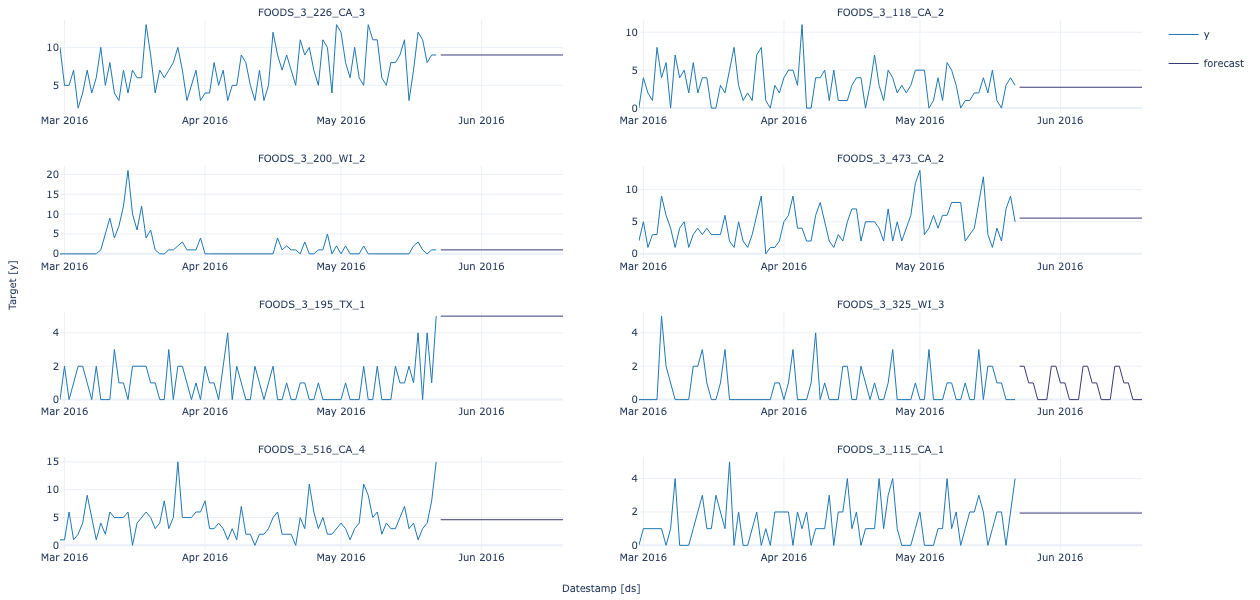

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)